# Diagnosing heart disease

In this notebook we train a machine learning model that learns to predict heart diseases.

We start by importing some libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Setup

*This code generates synthetic data that we will use in this notebook. You do not need to understand it in detail, but you still have to execute it.*

Press the play button below to setup the data file.

In [2]:
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)  # for reproducibility

# Generate synthetic data
n_samples = 200

# Generate ages
ages = np.random.normal(50, 20, n_samples)
ages = np.clip(ages, 0, 100)

# Generate SBP; base it partly on age (with random fluctuations)
base_sbp = 100 + (ages - 20) * 0.5
fluctuations = np.random.normal(0, 10, n_samples)
sbps = base_sbp + fluctuations
sbps = np.clip(sbps, 90, 180)  # clip values to a realistic range

# Determine the target based on age and SBP
heart_disease_risk = (ages - 40) / 20 + (sbps - 130) / 10
probabilities = 1 / (1 + np.exp(0.8*heart_disease_risk))
labels = (probabilities < np.random.rand(n_samples)).astype(int)

# Create a DataFrame
df = pd.DataFrame({
    'Age': ages,
    'SBP': sbps.astype(int),
    'HeartDisease': labels
})

# Save to a CSV if needed
df.to_csv('synthetic_heart_data.csv', index=False)

def plot_data(x, y, class_label, x_label, y_label):
    """
    Plots a scatter plot of x vs. y with different colors
    for individuals with and without heart disease.

    :param x: Array x
    :param y: Array y
    :param labels: Array indicating class labels (must be 0 or 1)
    """
    # Determine the colors based on labels
    colors = np.where(class_label == 1, 'red', 'blue')

    # Create the scatter plot
    plt.scatter(x, y, c=colors)

    # Set the labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(x_label + " vs. " + y_label)

    # Create custom legend
    # red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Heart Disease')
    # blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Heart Disease')
    # plt.legend(handles=[red_patch, blue_patch])

    # Show grid and plot
    plt.grid(True)
    plt.show()


# Loading and plotting the data (optional)

We now load the data from the file we have just written, and make a scatter plot out of it using matplotlib.

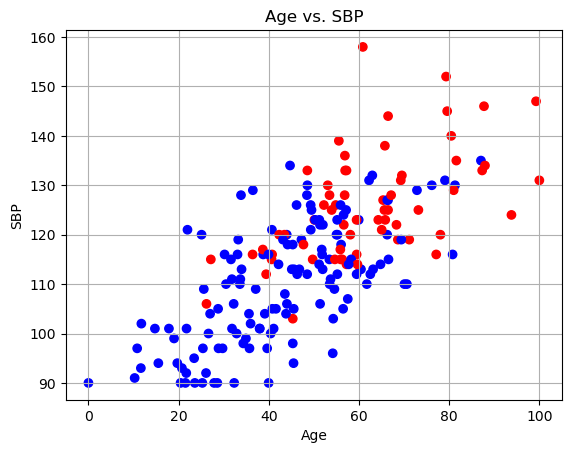

In [3]:
df = pd.read_csv("synthetic_heart_data.csv")

plot_data(df["Age"], df["SBP"], df["HeartDisease"], "Age", "SBP")

We now train a decision tree

In [4]:
X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X, y)

DecisionTreeClassifier(random_state=42)

## Drawing the tree

The cell below draws how the learned decision tree makes decisions. It consists of two blocks of code. The first block can be ignored, but you must still execute it.

In [5]:
import matplotlib.patches as mpatches

def plot_decision_boundary(model, X, y, title):
    h = .02
    X = X.to_numpy()
    y = y.to_numpy()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    contour = plt.contourf(xx, yy, Z, alpha=0.4, levels=[-0.1, 0.5, 1.1], colors=['blue', 'red'])
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.xlabel('Age')
    plt.ylabel("Systolic Blood Pressure (SBP)")

    no_heart_disease = mpatches.Patch(color="blue", label='No Heart Disease')
    heart_disease = mpatches.Patch(color="red", label='Heart Disease')
    plt.legend(handles=[no_heart_disease, heart_disease], loc="lower right")

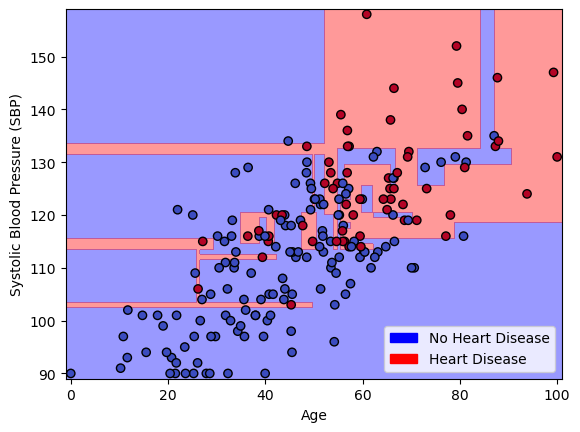

In [6]:
plot_decision_boundary(tree, X, y, "")

## Validating estimators

The tree above makes some significant mistakes when diagnosing heart diseases. The data plot shows that those whose age is above 50 and whose blood pressure is above 115 should be marked as having a heart disease. That is, upper right quadrant should be uniformly colored as red. However, there are some areas who are incorrectly colored as blue, whereas other areas are incorrectly marked as red.

To detect this problem, it is important to validate estimators in separate datasets that were not used to train the model. We can separate our dataset using the command `X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)`. This means that the dataset `X, y` will be separated into a training set `X_train, y_train` and a testing set `X_test, y_test`.

Use the information above to train and validate your model.

Accuracy of classif. tree on train data: 1.000
Accuracy of classif. tree on test data: 1.000


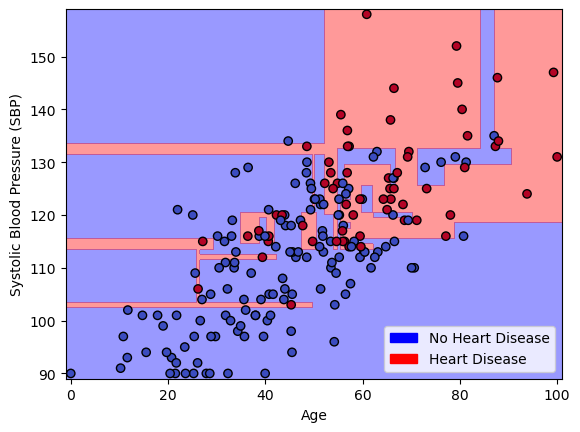

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Measure the quality of your decision tree in the test data.

from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_train, tree.predict(X_train))
acc_test = accuracy_score(y_test, tree.predict(X_test))
print("Accuracy of classif. tree on train data: {:.3f}".format(acc_train))
print("Accuracy of classif. tree on test data: {:.3f}".format(acc_test))

# Plot the tree
plot_decision_boundary(tree, X, y, "")

## Hyperparameter search

The cell above shows that training a tree with the default parameters produces a tree that does not work well. We must adjust the depth of the tree used during training.

We search for the optimal depth of our tree using `GridSearchCV` from the Python library `scikit-learn`.

Accuracy of classif. tree on train data: 0.800
Accuracy of classif. tree on test data: 0.775


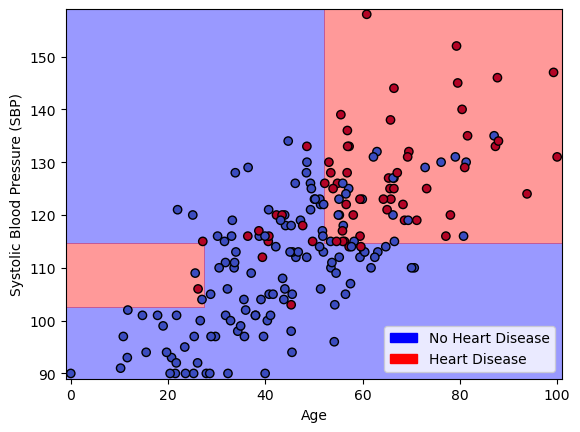

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

grid = {'max_depth' : range(2, 10)}
model = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=grid, cv=5)
model.fit(X_train, y_train)

acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, model.predict(X_test))
print("Accuracy of classif. tree on train data: {:.3f}".format(acc_train))
print("Accuracy of classif. tree on test data: {:.3f}".format(acc_test))

plot_decision_boundary(model, X, y, "")

Observe how the resulting tree achieves a substantially better accuracy. The accuracy is above 75%